In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM, Dense

2023-05-18 11:15:46.294263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df1 = pd.read_csv("city_day.csv")
df2 = pd.read_csv("city_hour.csv")
df3 = pd.read_csv("station_day.csv")
df4 = pd.read_csv("station_hour.csv", low_memory=False)
df5 = pd.read_csv("stations.csv")

In [3]:
#dropna
df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df4 = df4.dropna()
df5 = df5.dropna()

In [4]:
# removing outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25, numeric_only=True)
    Q3 = df.quantile(0.75, numeric_only=True)
    IQR = Q3 - Q1
    threshold = 1.5
    aligned_df = df.align(Q1, axis=1, copy=False)
    aligned_Q1 = aligned_df[0]
    
    return df[~((aligned_Q1 < (Q1 - threshold * IQR)) | (aligned_Q1 > (Q3 + threshold * IQR))).any(axis=1)]

In [5]:
df1 = remove_outliers(df1)
df1.head()

/tmp/ipykernel_18690/2037996344.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((aligned_Q1 < (Q1 - threshold * IQR)) | (aligned_Q1 > (Q3 + threshold * IQR))).any(axis=1)]


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
2137,Amaravati,2017-12-09,74.28,141.22,6.10,44.97,28.88,15.73,0.09,21.90,60.62,0.26,4.79,0.16,196.0,Moderate
2138,Amaravati,2017-12-10,50.32,102.77,1.73,33.85,19.41,12.56,0.10,13.65,68.15,0.20,4.29,0.10,132.0,Moderate
2139,Amaravati,2017-12-11,58.47,115.27,4.93,41.64,26.15,15.20,0.16,18.37,73.75,0.23,5.51,0.16,147.0,Moderate
2140,Amaravati,2017-12-12,89.35,131.48,7.97,42.10,28.88,21.24,0.24,7.42,44.67,0.28,7.01,0.19,179.0,Moderate
2141,Amaravati,2017-12-13,64.42,99.74,7.20,34.78,24.36,17.63,0.15,5.81,50.16,0.24,6.11,0.14,145.0,Moderate


In [6]:
df2 = remove_outliers(df2)
df2.head()

/tmp/ipykernel_18690/2037996344.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((aligned_Q1 < (Q1 - threshold * IQR)) | (aligned_Q1 > (Q3 + threshold * IQR))).any(axis=1)]


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
50909,Amaravati,2017-11-26 06:00:00,98.25,137.75,0.38,31.75,17.18,9.00,0.10,12.12,89.20,0.33,14.33,0.10,186.0,Moderate
50910,Amaravati,2017-11-26 07:00:00,103.00,144.75,1.37,40.50,22.70,9.67,0.10,10.42,36.75,0.30,12.40,0.10,189.0,Moderate
50911,Amaravati,2017-11-26 08:00:00,97.75,143.00,2.00,38.48,22.12,10.73,0.10,16.12,92.12,0.30,11.03,0.15,191.0,Moderate
50923,Amaravati,2017-11-26 20:00:00,80.00,159.50,3.97,41.65,25.40,11.25,0.18,12.47,70.07,0.30,9.22,0.10,181.0,Moderate
50924,Amaravati,2017-11-26 21:00:00,84.00,160.00,0.73,48.07,26.20,11.20,0.50,12.10,56.85,0.28,9.58,0.10,181.0,Moderate


In [7]:
df3 = remove_outliers(df3)
df3.head()

/tmp/ipykernel_18690/2037996344.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((aligned_Q1 < (Q1 - threshold * IQR)) | (aligned_Q1 > (Q3 + threshold * IQR))).any(axis=1)]


,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
15,AP001,2017-12-09,74.28,141.22,6.10,44.97,28.88,15.73,0.09,21.90,60.62,0.26,4.79,0.16,196.0,Moderate
16,AP001,2017-12-10,50.32,102.77,1.73,33.85,19.41,12.56,0.10,13.65,68.15,0.20,4.29,0.10,132.0,Moderate
17,AP001,2017-12-11,58.47,115.27,4.93,41.64,26.15,15.20,0.16,18.37,73.75,0.23,5.51,0.16,147.0,Moderate
18,AP001,2017-12-12,89.35,131.48,7.97,42.10,28.88,21.24,0.24,7.42,44.67,0.28,7.01,0.19,179.0,Moderate
19,AP001,2017-12-13,64.42,99.74,7.20,34.78,24.36,17.63,0.15,5.81,50.16,0.24,6.11,0.14,145.0,Moderate


In [8]:
df4 = remove_outliers(df4)
df4.head()

/tmp/ipykernel_18690/2037996344.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((aligned_Q1 < (Q1 - threshold * IQR)) | (aligned_Q1 > (Q3 + threshold * IQR))).any(axis=1)]


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
37,AP001,2017-11-26 06:00:00,98.25,137.75,0.38,31.75,17.18,9.00,0.10,12.12,89.20,0.33,14.33,0.10,186.0,Moderate
38,AP001,2017-11-26 07:00:00,103.00,144.75,1.37,40.50,22.70,9.67,0.10,10.42,36.75,0.30,12.40,0.10,189.0,Moderate
51,AP001,2017-11-26 20:00:00,80.00,159.50,3.97,41.65,25.40,11.25,0.18,12.47,70.07,0.30,9.22,0.10,181.0,Moderate
52,AP001,2017-11-26 21:00:00,84.00,160.00,0.73,48.07,26.20,11.20,0.50,12.10,56.85,0.28,9.58,0.10,181.0,Moderate
53,AP001,2017-11-26 22:00:00,95.75,172.75,1.35,34.12,19.25,9.83,0.53,10.23,48.52,0.35,10.65,0.15,181.0,Moderate


In [9]:
## focus on delhi city
delhi_daily = df1[df1["City"] == "Delhi"]
delhi_daily = delhi_daily.drop(columns=['City'])
delhi_hourly = df2[df2['City'] == 'Delhi']
delhi_hourly = delhi_hourly.drop(columns=['City'])

delhi_daily.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10472,2015-09-01,73.78,230.34,17.83,27.42,45.70,18.96,1.28,10.45,61.33,2.15,5.67,3.27,210.0,Poor
10476,2015-09-05,76.43,201.89,24.24,29.50,52.24,26.99,1.38,16.93,56.59,2.89,6.72,3.55,266.0,Poor
10477,2015-09-06,61.69,168.63,17.36,27.81,41.56,23.17,1.19,16.71,49.32,2.17,5.08,3.21,174.0,Moderate
10478,2015-09-07,55.19,179.42,27.91,35.49,61.81,23.76,1.04,12.97,52.24,3.09,7.72,6.26,199.0,Moderate
10479,2015-09-08,63.79,219.51,25.93,38.36,60.12,27.35,1.07,10.92,61.95,3.40,9.09,3.45,217.0,Poor


In [11]:
delhi_hourly.head()

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
247414,2015-04-04 11:00:00,44.28,42.24,11.26,24.98,32.06,34.28,1.87,8.35,33.16,1.50,4.51,2.41,209.0,Poor
247617,2015-04-12 22:00:00,66.39,116.14,9.69,55.37,59.89,32.28,1.43,17.42,64.50,2.93,10.36,1.80,266.0,Poor
247618,2015-04-12 23:00:00,76.10,114.36,12.74,56.10,64.55,33.72,2.03,12.21,64.89,2.54,8.80,2.02,262.0,Poor
247622,2015-04-13 03:00:00,135.96,154.22,18.59,46.85,59.92,38.50,1.79,15.78,85.62,4.04,14.68,2.22,262.0,Poor
247623,2015-04-13 04:00:00,105.73,111.65,13.67,49.66,55.44,42.97,1.75,17.46,51.93,3.05,9.66,2.19,252.0,Poor


In [12]:
delhi_hourly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11756 entries, 247414 to 293363
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Datetime    11756 non-null  object 
 1   PM2.5       11756 non-null  float64
 2   PM10        11756 non-null  float64
 3   NO          11756 non-null  float64
 4   NO2         11756 non-null  float64
 5   NOx         11756 non-null  float64
 6   NH3         11756 non-null  float64
 7   CO          11756 non-null  float64
 8   SO2         11756 non-null  float64
 9   O3          11756 non-null  float64
 10  Benzene     11756 non-null  float64
 11  Toluene     11756 non-null  float64
 12  Xylene      11756 non-null  float64
 13  AQI         11756 non-null  float64
 14  AQI_Bucket  11756 non-null  object 
dtypes: float64(13), object(2)
memory usage: 1.4+ MB


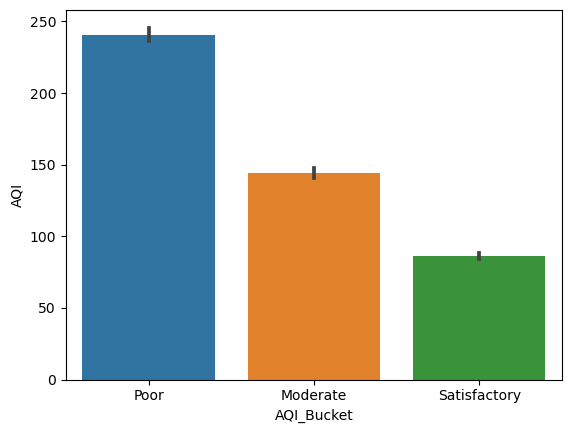

In [54]:
sns.barplot(x='AQI_Bucket', y='AQI', data=delhi_daily)
plt.savefig('AQI_Bucket-vs-AQI-daily.png')

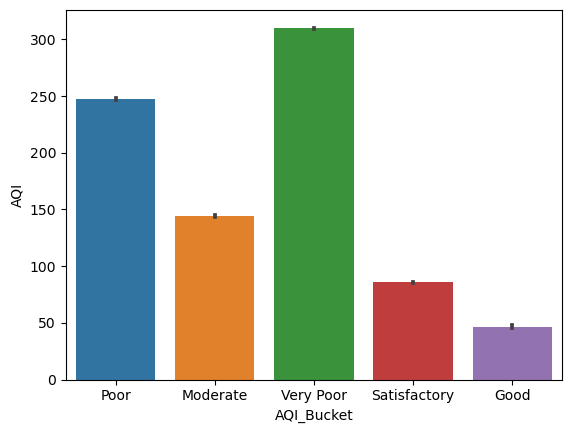

In [51]:
sns.barplot(x='AQI_Bucket', y='AQI', data=delhi_hourly)
plt.savefig('AQI_Bucket-vs-AQI-hourly.png')

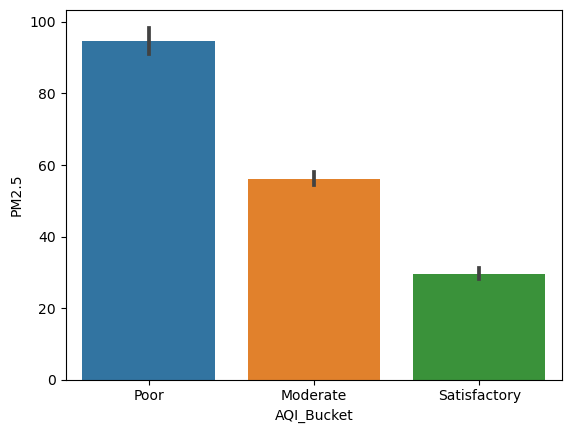

In [52]:
sns.barplot(x='AQI_Bucket', y='PM2.5', data=delhi_daily)
plt.savefig('AQI_Bucket-vs-Pm2.5-daily.png')

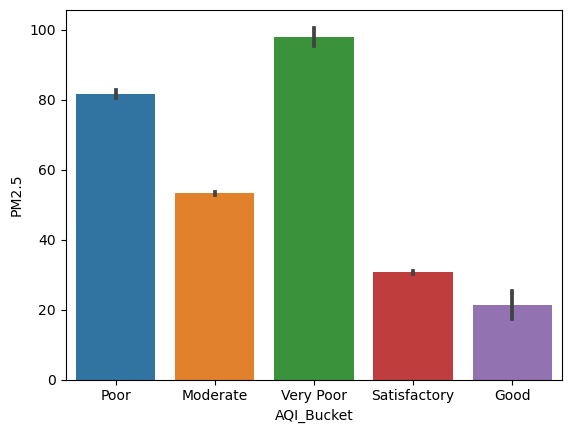

In [56]:
sns.barplot(x='AQI_Bucket', y='PM2.5', data=delhi_hourly)
plt.savefig('AQI_Bucket-vs-Pm2.5_hourly.png')

In [17]:
# timeseries AQI for year 2016

delhi_daily['Date'] = pd.to_datetime(delhi_daily['Date'])

# Selecting a date range
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Filter the DataFrame based on the date range
filtered_df = delhi_daily[(delhi_daily['Date'] >= start_date) & (delhi_daily['Date'] <= end_date)]

filtered_df

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
11228,2017-09-26,66.12,114.15,23.12,27.52,18.35,34.54,0.60,7.13,30.45,0.25,1.38,0.13,131.0,Moderate
11229,2017-09-27,80.94,125.39,26.98,21.39,22.31,50.34,0.61,6.62,29.26,0.35,1.74,0.12,165.0,Moderate
11231,2017-09-29,89.38,140.94,37.45,29.45,18.61,41.19,0.45,7.17,40.26,0.44,1.82,0.13,172.0,Moderate
11232,2017-09-30,74.20,125.73,21.10,26.08,8.59,44.10,0.30,6.64,38.44,0.22,1.73,0.10,137.0,Moderate
11233,2017-10-01,68.47,120.56,25.43,28.66,14.66,50.15,0.46,3.46,32.90,0.46,2.34,0.03,131.0,Moderate
11234,2017-10-02,63.41,128.15,22.86,25.20,12.10,39.12,0.43,2.94,30.10,0.54,2.43,0.05,132.0,Moderate
11235,2017-10-03,69.45,127.48,22.75,26.09,11.47,31.36,0.20,5.81,34.34,0.24,1.27,0.10,115.0,Moderate
11236,2017-10-04,76.81,138.81,24.88,28.99,14.09,39.43,0.19,11.70,35.79,0.35,2.07,0.08,151.0,Moderate
11237,2017-10-05,75.73,125.31,15.35,24.45,13.80,37.22,0.27,11.96,36.81,0.25,1.59,0.09,180.0,Moderate
11238,2017-10-06,79.81,111.43,14.82,27.44,12.19,31.48,0.33,13.91,38.67,0.39,2.11,0.15,183.0,Moderate


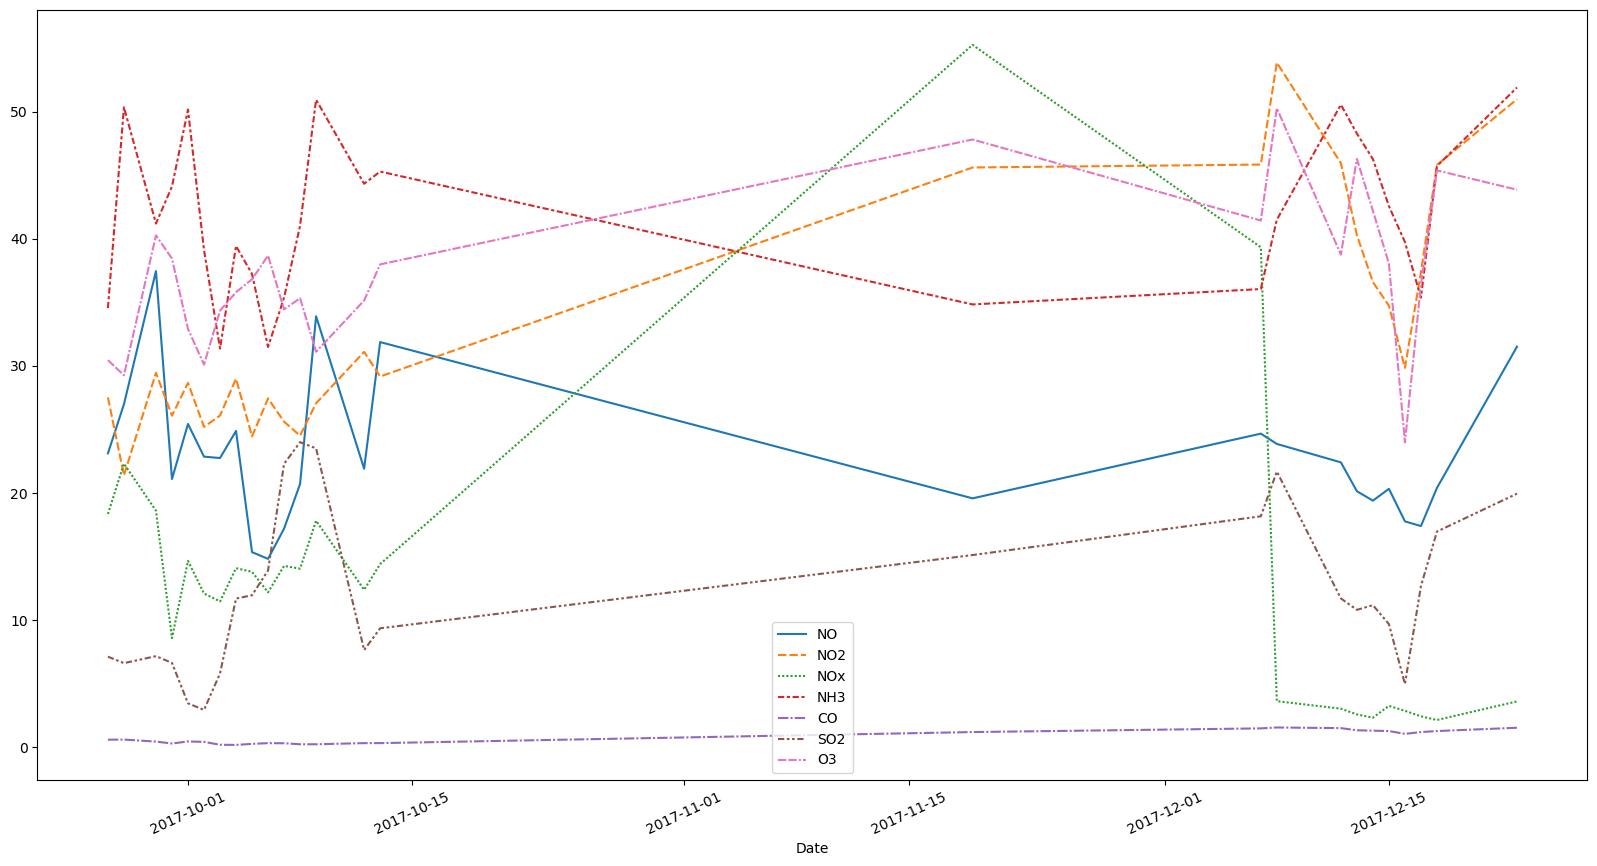

In [18]:
# sns.lineplot(x = "Date", y = "AQI",
#              data = filtered_df)
plt.figure(figsize=(20,10))
filtered_df.set_index('Date', inplace=True)
sns.lineplot(data=filtered_df[['NO','NO2','NOx','NH3','CO','SO2','O3']])
  
plt.xticks(rotation = 25)
plt.savefig('delhi-2017-pollutants.png')

In [19]:
delhi_daily['Date'] = pd.to_datetime(delhi_daily['Date'])

# Selecting a date range
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2018-12-31')

# Filter the DataFrame based on the date range
filtered_df2 = delhi_daily[(delhi_daily['Date'] >= start_date) & (delhi_daily['Date'] <= end_date)]

filtered_df2.head(10)

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
11228,2017-09-26,66.12,114.15,23.12,27.52,18.35,34.54,0.60,7.13,30.45,0.25,1.38,0.13,131.0,Moderate
11229,2017-09-27,80.94,125.39,26.98,21.39,22.31,50.34,0.61,6.62,29.26,0.35,1.74,0.12,165.0,Moderate
11231,2017-09-29,89.38,140.94,37.45,29.45,18.61,41.19,0.45,7.17,40.26,0.44,1.82,0.13,172.0,Moderate
11232,2017-09-30,74.20,125.73,21.10,26.08,8.59,44.10,0.30,6.64,38.44,0.22,1.73,0.10,137.0,Moderate
11233,2017-10-01,68.47,120.56,25.43,28.66,14.66,50.15,0.46,3.46,32.90,0.46,2.34,0.03,131.0,Moderate
11234,2017-10-02,63.41,128.15,22.86,25.20,12.10,39.12,0.43,2.94,30.10,0.54,2.43,0.05,132.0,Moderate
11235,2017-10-03,69.45,127.48,22.75,26.09,11.47,31.36,0.20,5.81,34.34,0.24,1.27,0.10,115.0,Moderate
11236,2017-10-04,76.81,138.81,24.88,28.99,14.09,39.43,0.19,11.70,35.79,0.35,2.07,0.08,151.0,Moderate
11237,2017-10-05,75.73,125.31,15.35,24.45,13.80,37.22,0.27,11.96,36.81,0.25,1.59,0.09,180.0,Moderate
11238,2017-10-06,79.81,111.43,14.82,27.44,12.19,31.48,0.33,13.91,38.67,0.39,2.11,0.15,183.0,Moderate


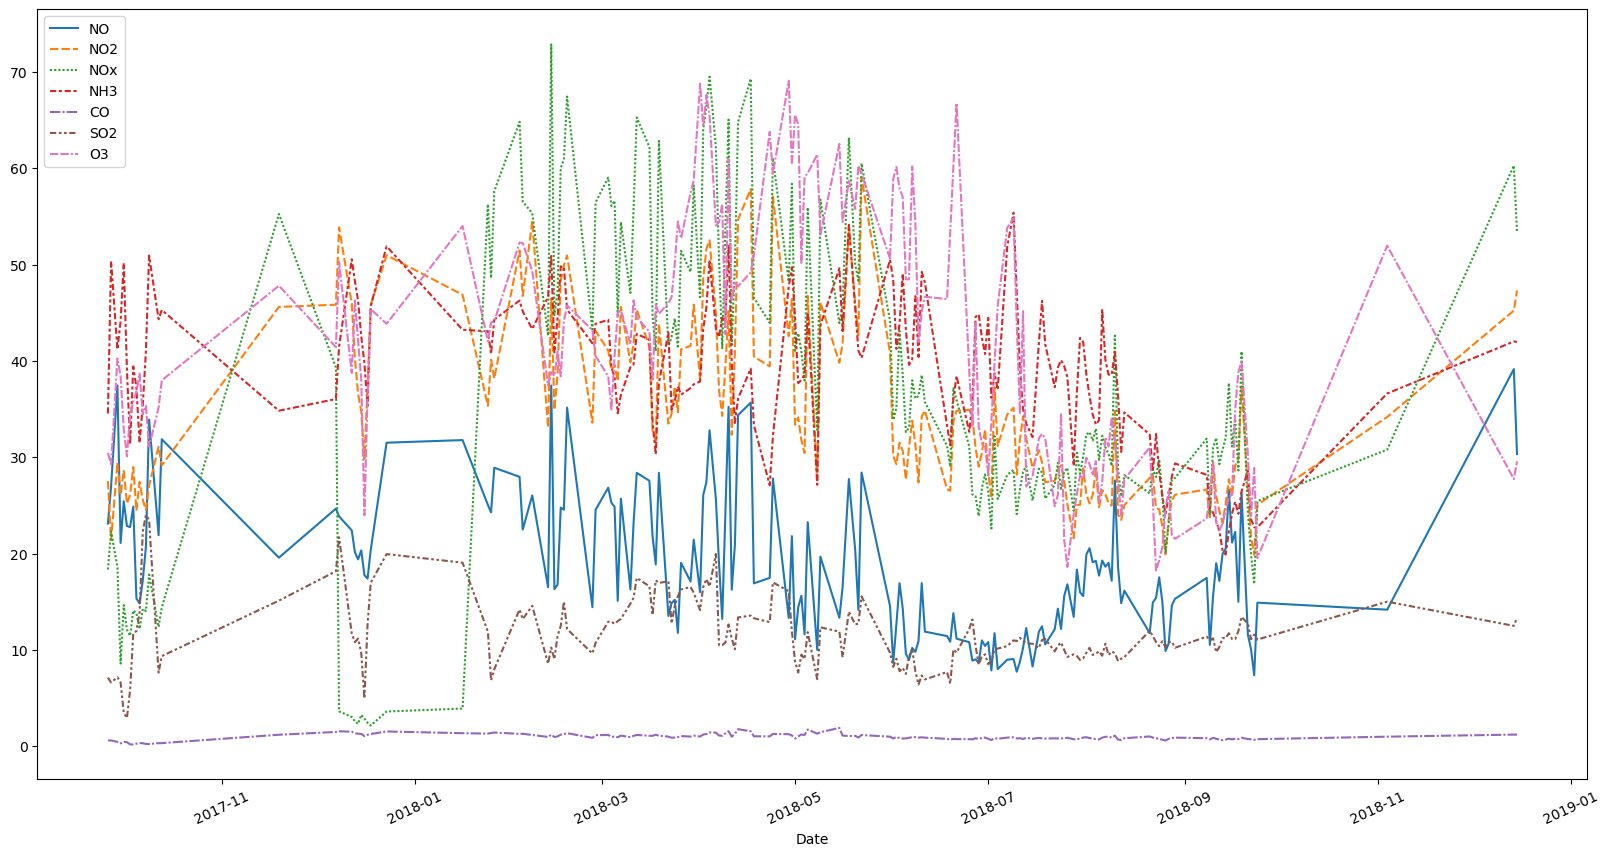

In [20]:
plt.figure(figsize=(20,10))
filtered_df2.set_index('Date', inplace=True)
sns.lineplot(data=filtered_df2[['NO','NO2','NOx','NH3','CO','SO2','O3']])
  
plt.xticks(rotation = 25)
plt.savefig('delhi-2017 to 2018-pollutants.png')

In [21]:
# get stations in delhi
delhi_stations = df5[df5['City'] == 'Delhi']
delhi_stations.head()

,StationId,StationName,City,State,Status
17,DL001,"Alipur, Delhi - DPCC",Delhi,Delhi,Active
18,DL002,"Anand Vihar, Delhi - DPCC",Delhi,Delhi,Active
19,DL003,"Ashok Vihar, Delhi - DPCC",Delhi,Delhi,Active
20,DL004,"Aya Nagar, Delhi - IMD",Delhi,Delhi,Active
21,DL005,"Bawana, Delhi - DPCC",Delhi,Delhi,Active


In [22]:
delhi_stations_ids = delhi_stations['StationId'].tolist()
print(delhi_stations_ids)

['DL001', 'DL002', 'DL003', 'DL004', 'DL005', 'DL006', 'DL007', 'DL008', 'DL009', 'DL010', 'DL011', 'DL012', 'DL013', 'DL014', 'DL015', 'DL016', 'DL017', 'DL018', 'DL019', 'DL020', 'DL021', 'DL022', 'DL023', 'DL024', 'DL025', 'DL026', 'DL027', 'DL028', 'DL029', 'DL030', 'DL031', 'DL032', 'DL033', 'DL034', 'DL035', 'DL036', 'DL037', 'DL038']


In [23]:
#delhi stations data
delhi_stations_daily = df3[df3['StationId'].isin(delhi_stations_ids)]
delhi_stations_daily.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
5930,DL001,2018-12-14,98.81,158.25,9.09,68.82,44.01,26.74,0.59,18.66,18.43,1.10,18.50,0.00,199.0,Moderate
5969,DL001,2019-01-22,39.77,46.11,2.14,52.05,29.42,27.64,0.45,21.19,30.98,0.44,1.27,0.02,171.0,Moderate
5973,DL001,2019-01-26,88.94,135.61,2.73,45.81,26.61,26.01,0.59,23.34,32.51,0.58,1.65,0.00,190.0,Moderate
5995,DL001,2019-02-17,88.43,152.27,5.03,48.69,30.00,22.48,0.66,23.72,36.31,0.51,11.74,0.14,221.0,Poor
6000,DL001,2019-02-22,65.97,118.76,5.54,50.62,31.44,25.23,0.53,22.70,29.35,0.94,5.34,1.44,146.0,Moderate


In [24]:
delhi_stations_hourly = df4[df4['StationId'].isin(delhi_stations_ids)]
delhi_stations_hourly.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
141235,DL001,2018-11-15 21:00:00,132.50,226.00,13.53,84.57,55.95,23.18,0.45,13.75,3.88,2.60,26.92,0.15,237.0,Poor
141444,DL001,2018-11-24 14:00:00,58.50,162.25,1.82,52.10,29.25,22.88,0.35,19.15,85.70,1.45,19.90,0.03,169.0,Moderate
141445,DL001,2018-11-24 15:00:00,52.25,148.50,1.82,34.75,19.97,17.38,0.10,17.03,86.12,0.70,7.00,0.00,169.0,Moderate
141447,DL001,2018-11-24 17:00:00,48.75,126.75,1.70,32.07,18.47,16.93,0.10,18.50,73.33,0.43,4.43,0.00,170.0,Moderate
141449,DL001,2018-11-24 19:00:00,67.75,229.50,9.82,83.38,52.35,19.07,0.82,22.65,3.38,1.50,23.70,0.13,171.0,Moderate


# preparing data for the models


hourly data is prefered here since it is more precise and accurate.

In [25]:
X_data1 = delhi_hourly.drop(columns=['Datetime', 'AQI', 'AQI_Bucket'])

Y_data1 = delhi_hourly['AQI']

## LSTM-based Air Quality Prediction

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_data1, Y_data1, test_size=0.2, random_state=42)

In [27]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)


In [28]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Length of input sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, sequence_length)

In [29]:
# Building the LSTM model
model = Sequential()
num_features = 12
model.add(LSTM(64, input_shape=(sequence_length, num_features)))
model.add(Dense(1))  # Output layer with a single neuron

2023-05-18 11:16:08.310052: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-05-18 11:16:08.812499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 11:16:08.816145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 11:16:08.8

In [30]:
# compiling and training the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32)

Epoch 1/10


2023-05-18 11:16:09.532107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 11:16:09.537882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 11:16:09.541284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

294/294 [==============================] - 11s 27ms/step - loss: 0.0497
Epoch 2/10
294/294 [==============================] - 7s 25ms/step - loss: 0.0465
Epoch 3/10
294/294 [==============================] - 8s 26ms/step - loss: 0.0463
Epoch 4/10
294/294 [==============================] - 7s 25ms/step - loss: 0.0463
Epoch 5/10
294/294 [==============================] - 5s 19ms/step - loss: 0.0462
Epoch 6/10
294/294 [==============================] - 6s 21ms/step - loss: 0.0463
Epoch 7/10
294/294 [==============================] - 7s 24ms/step - loss: 0.0463
Epoch 8/10
294/294 [==============================] - 7s 25ms/step - loss: 0.0462
Epoch 9/10
294/294 [==============================] - 7s 25ms/step - loss: 0.0462
Epoch 10/10
294/294 [==============================] - 6s 22ms/step - loss: 0.0462


In [31]:
# evaluating the model
loss = model.evaluate(X_test_seq, y_test_seq)
print("Loss:", loss)


2023-05-18 11:17:34.663834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 11:17:34.667173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 11:17:34.671020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

74/74 [==============================] - 2s 15ms/step - loss: 0.0469
Loss: 0.046866875141859055


In [32]:
# make predictions
predictions = model.predict(X_test_seq)

2023-05-18 11:17:36.706359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 11:17:36.709553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 11:17:36.711578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

74/74 [==============================] - 2s 13ms/step


In [33]:
# Accessing predicted values for the first input sequence
first_sequence_predictions = predictions[0]

print("Predictions shape:", predictions.shape)
print("First sequence predictions:", first_sequence_predictions)
# print("Specific prediction:", specific_prediction)

Predictions shape: (2342, 1)
First sequence predictions: [0.35658044]


# Random Forest Regression for Air Quality Analysis

In [34]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [35]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
y_pred = model.predict(X_test)

In [37]:
mse = mean_squared_error(y_test, y_pred)
mse

1171.352511734694

In [38]:
r2 = r2_score(y_test, y_pred)
r2

0.7601133022822968

# SVR for Air Quality Analysis

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
model = SVR(kernel='rbf')

In [41]:
# Training
model.fit(X_train_scaled, y_train)

SVR()

In [42]:
y_pred2 = model.predict(X_test_scaled)

In [43]:
mse = mean_squared_error(y_test, y_pred2)
mse

1827.1940604165354

In [44]:
r2 = r2_score(y_test, y_pred2)
r2

0.6258004786333684

In [45]:
print(predictions.shape)
print(y_pred.shape)
print(y_pred2.shape)

(2342, 1)
(2352,)
(2352,)


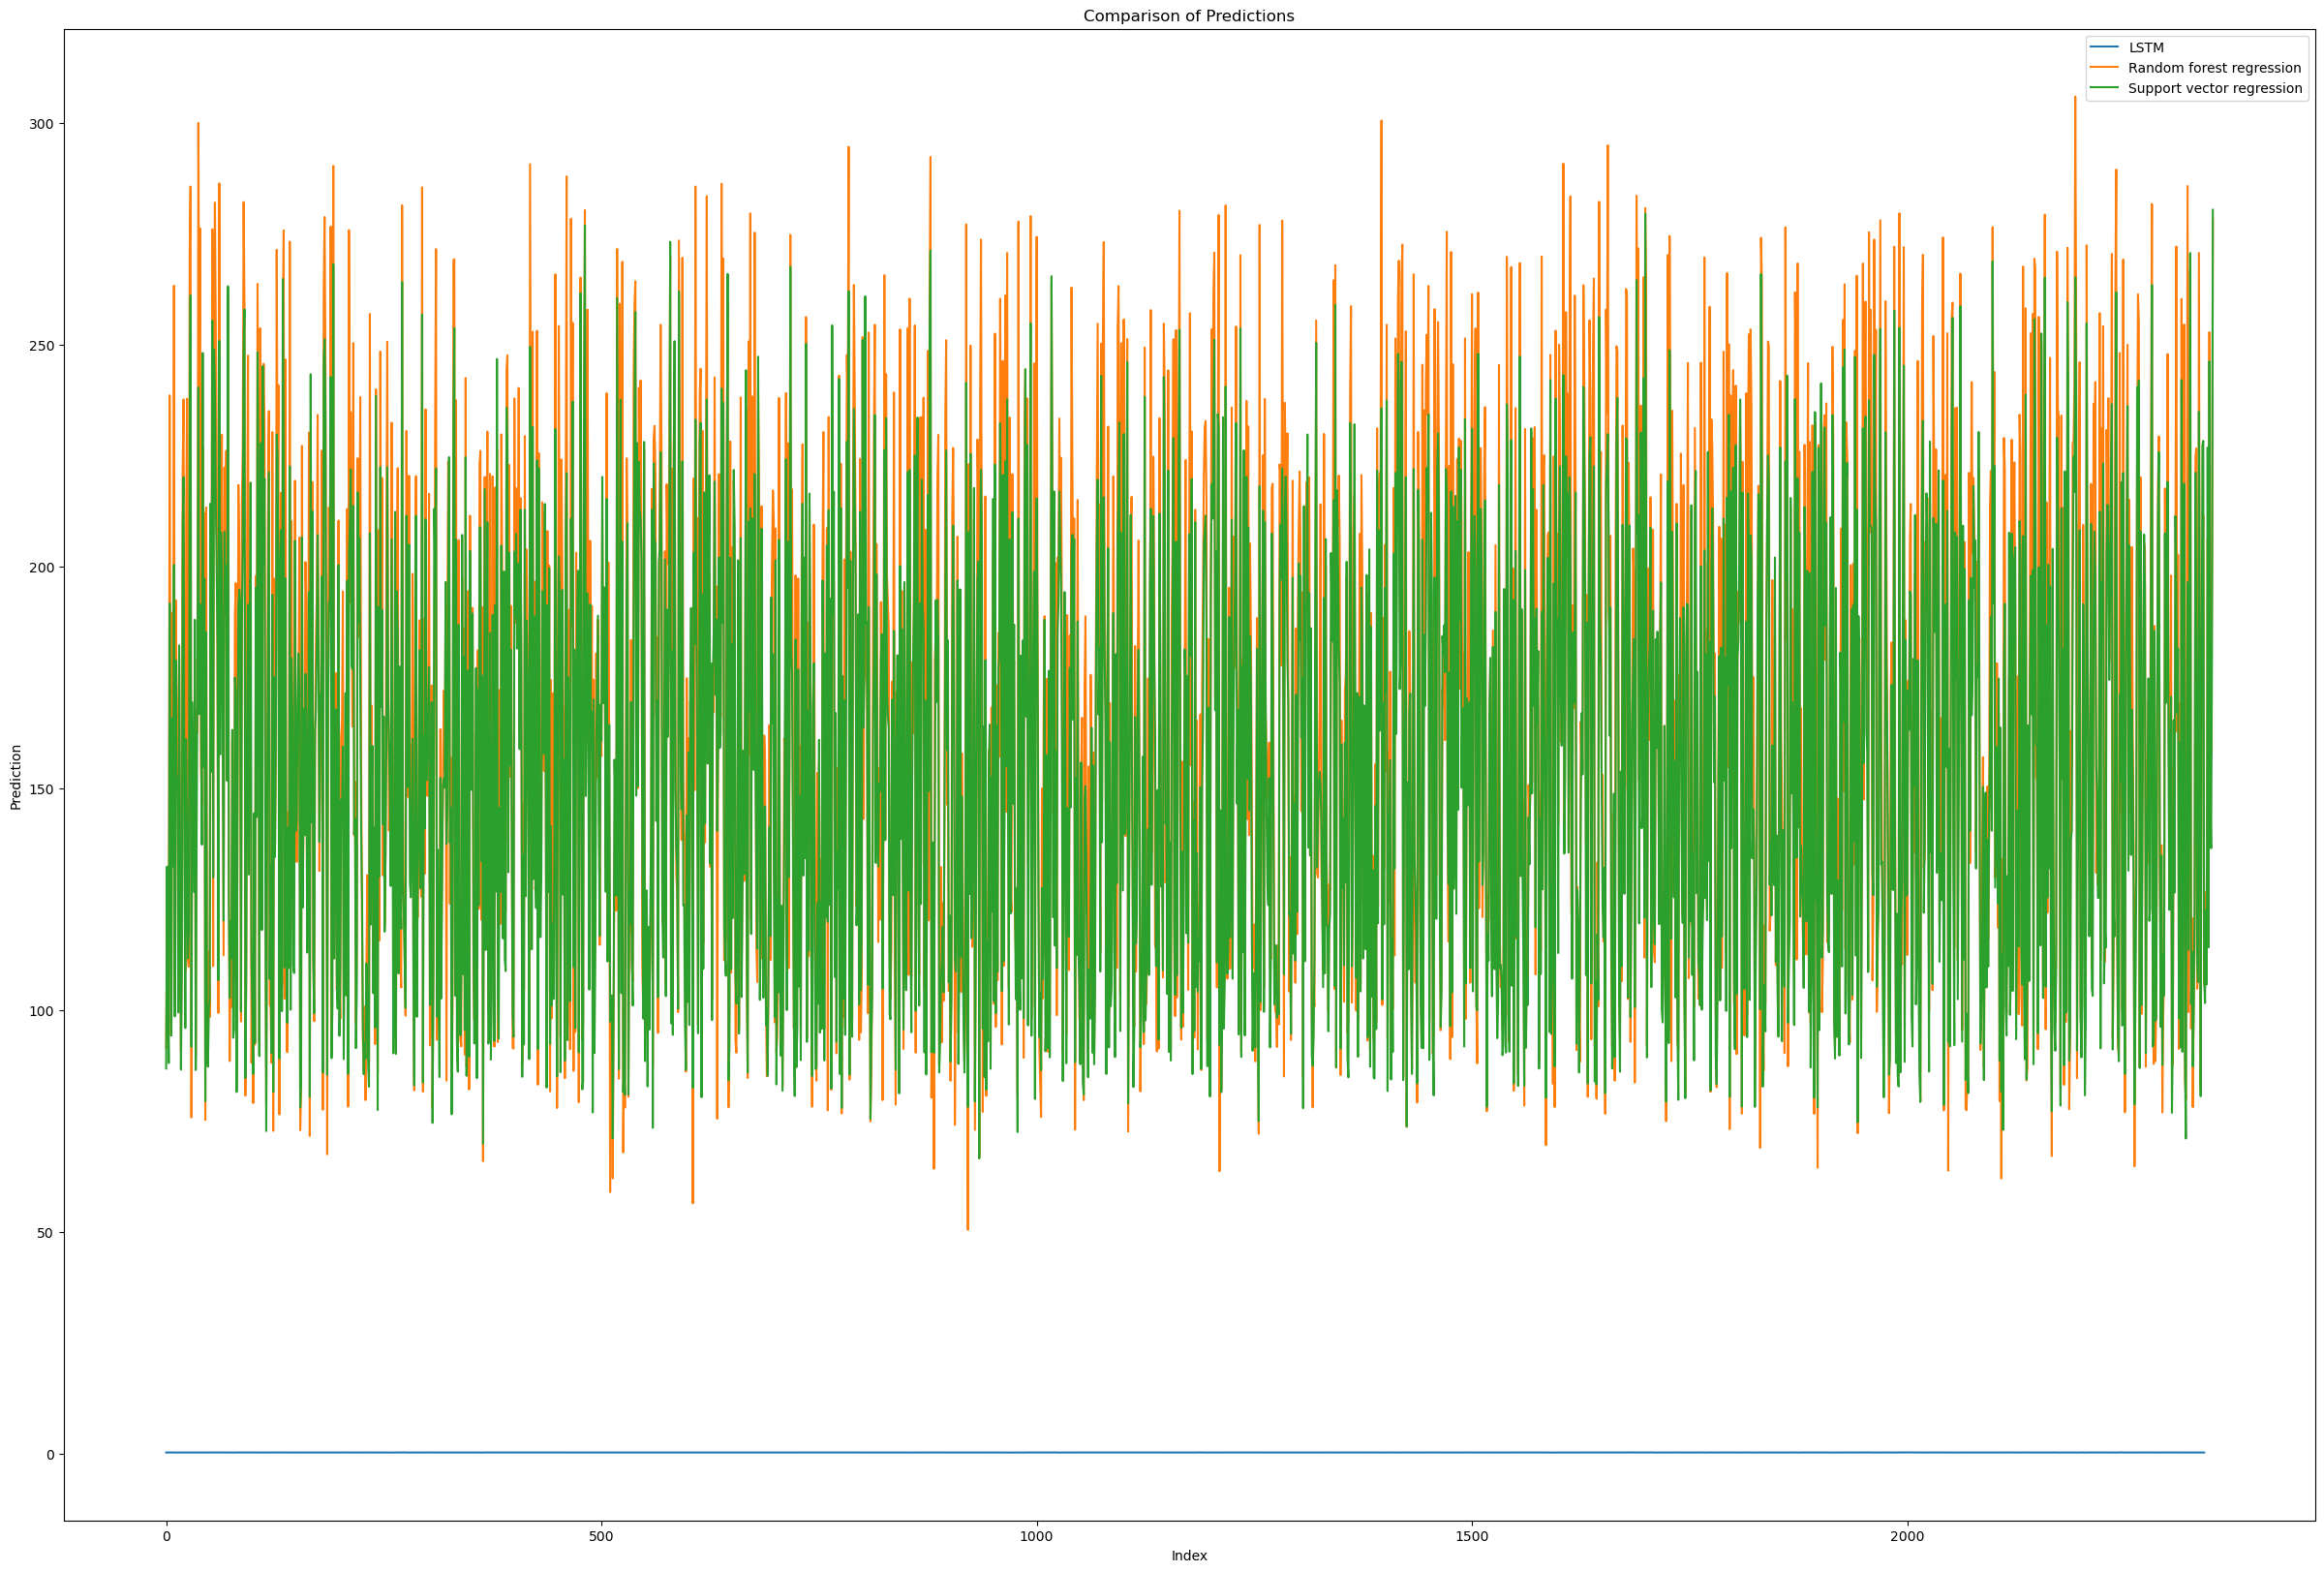

In [57]:

# Reshape predictions
predictions_reshaped = predictions.reshape(-1)

# Plot the predictions
plt.figure(figsize=(30, 20))
plt.plot(predictions_reshaped, label='LSTM')
plt.plot(y_pred, label='Random forest regression')
plt.plot(y_pred2, label='Support vector regression')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Comparison of Predictions')
plt.savefig('Comparison_of-Predictions.png')